In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split, RandomizedSearchCV, GridSearchCV
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error, r2_score


In [6]:
data = pd.read_csv(r'F:\GIT_Projects\Regression model\bike_share\day.csv')

In [7]:
# Display the first few rows of the dataset
print("Sample of the Bike Sharing Demand dataset:")
print(data.head())

Sample of the Bike Sharing Demand dataset:
   instant      dteday  season  yr  mnth  holiday  weekday  workingday  \
0        1  2011-01-01       1   0     1        0        6           0   
1        2  2011-01-02       1   0     1        0        0           0   
2        3  2011-01-03       1   0     1        0        1           1   
3        4  2011-01-04       1   0     1        0        2           1   
4        5  2011-01-05       1   0     1        0        3           1   

   weathersit      temp     atemp       hum  windspeed  casual  registered  \
0           2  0.344167  0.363625  0.805833   0.160446     331         654   
1           2  0.363478  0.353739  0.696087   0.248539     131         670   
2           1  0.196364  0.189405  0.437273   0.248309     120        1229   
3           1  0.200000  0.212122  0.590435   0.160296     108        1454   
4           1  0.226957  0.229270  0.436957   0.186900      82        1518   

    cnt  
0   985  
1   801  
2  1349  
3  

In [8]:
# Define features and target
features = ['season', 'yr', 'mnth', 'holiday', 'weekday', 'workingday', 'weathersit', 'temp', 'atemp', 'hum', 'windspeed']
target = 'cnt'

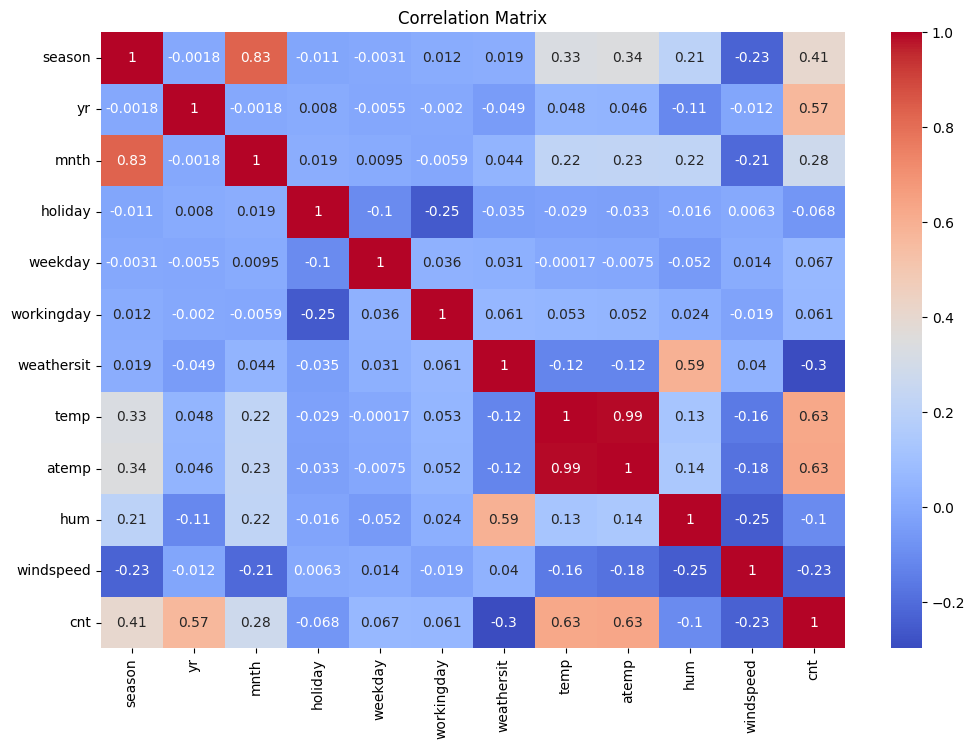

In [9]:
# Exploratory Data Analysis (EDA)
# Correlation matrix
plt.figure(figsize=(12, 8))
sns.heatmap(data[features + [target]].corr(), annot=True, cmap='coolwarm')
plt.title('Correlation Matrix')
plt.show()

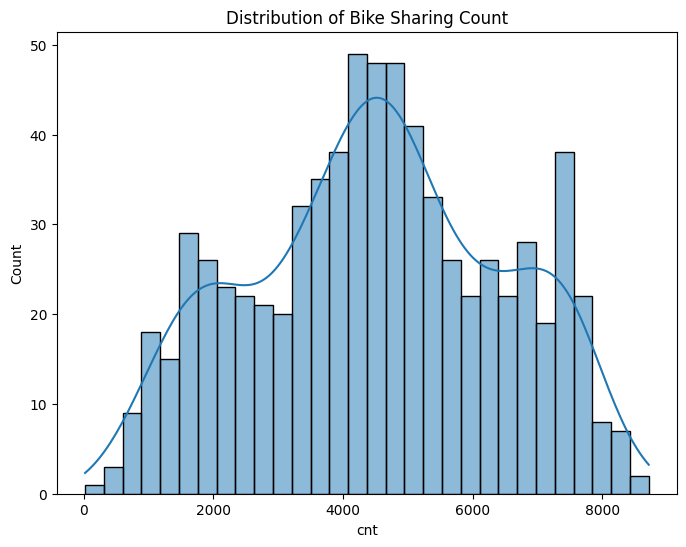

In [10]:
# Distribution of target variable
plt.figure(figsize=(8, 6))
sns.histplot(data[target], bins=30, kde=True)
plt.title('Distribution of Bike Sharing Count')
plt.show()


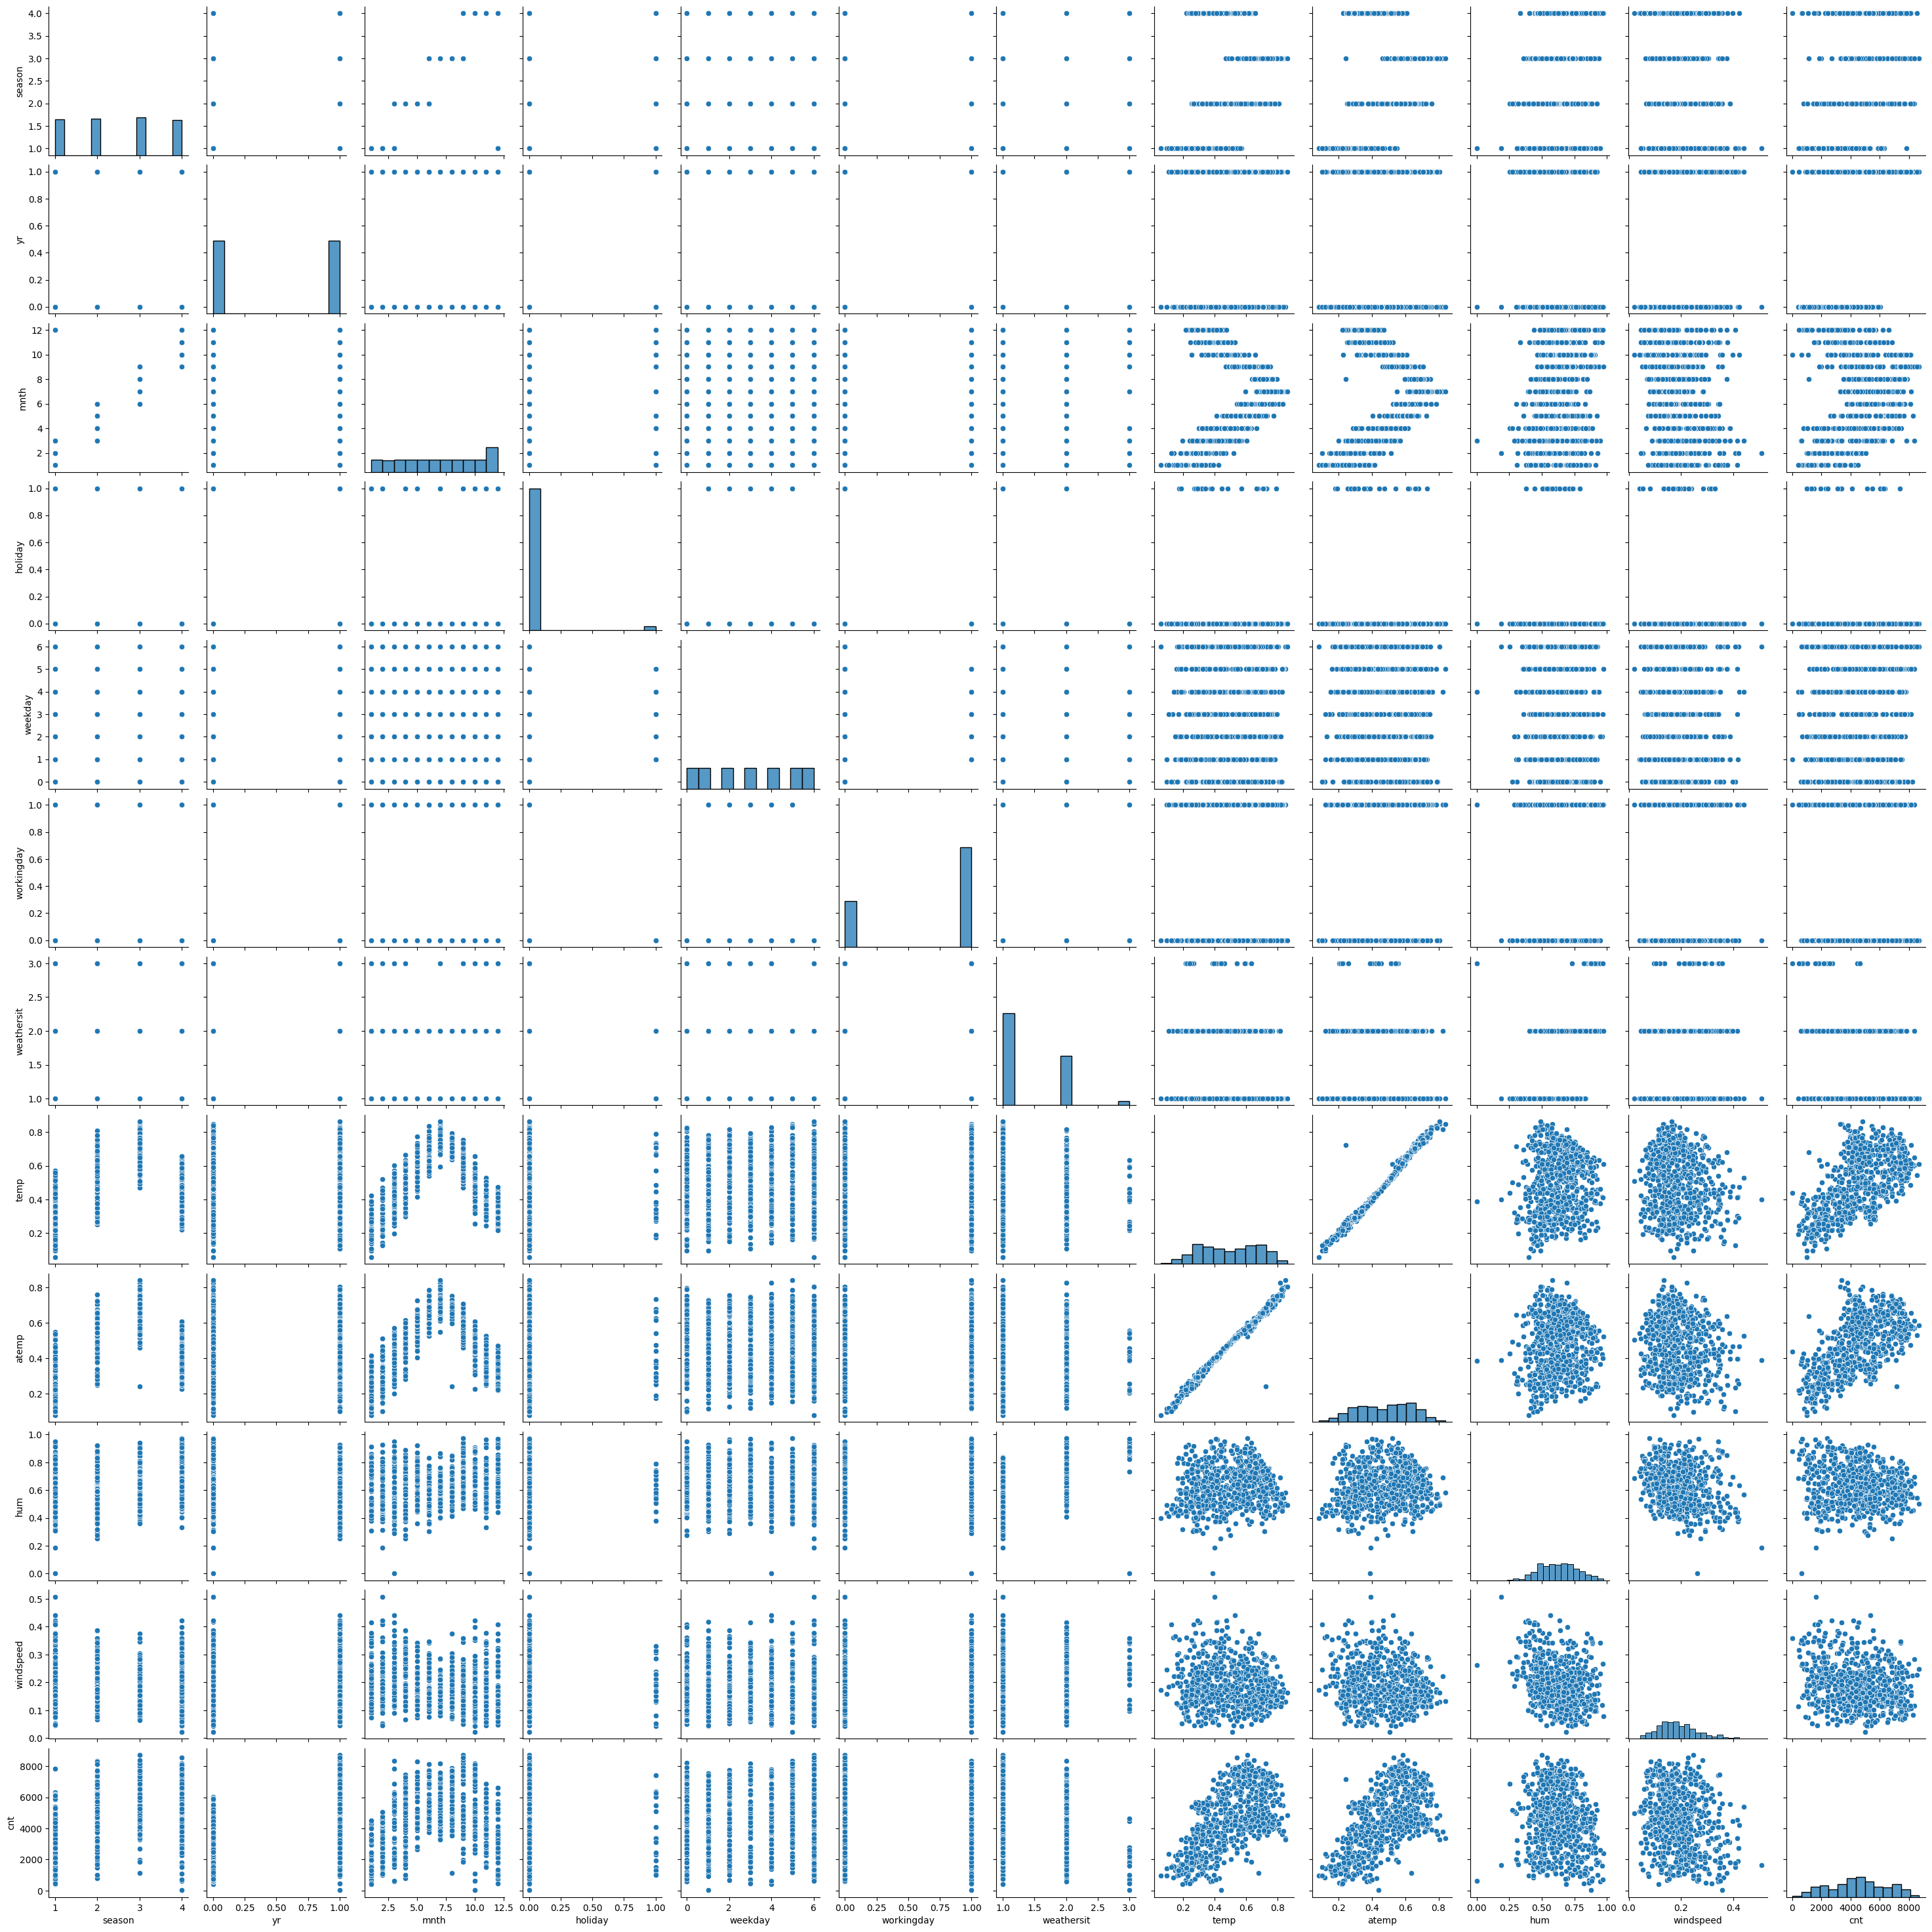

In [11]:

# Scatter plots
sns.pairplot(data[features + [target]])
plt.show()

In [12]:
# Identify numeric and categorical features
numeric_features = ['temp', 'atemp', 'hum', 'windspeed']
categorical_features = ['season', 'yr', 'mnth', 'holiday', 'weekday', 'workingday', 'weathersit']


In [13]:
# Preprocessing for numeric features: impute missing values and scale
numeric_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='mean')),
    ('scaler', StandardScaler())
])

In [14]:
# Preprocessing for categorical features: impute missing values and one-hot encode
categorical_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='most_frequent')),
    ('onehot', OneHotEncoder(handle_unknown='ignore'))
])

In [15]:
# Combine preprocessing steps
preprocessor = ColumnTransformer(
    transformers=[
        ('num', numeric_transformer, numeric_features),
        ('cat', categorical_transformer, categorical_features)
    ])

In [16]:

# Define the pipeline
pipeline = Pipeline(steps=[
    ('preprocessor', preprocessor),
    ('regressor', RandomForestRegressor(random_state=42))
])

In [17]:
# Split data into training and testing sets
X = data[features]
y = data[target]
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)


In [18]:
# Fit the pipeline
pipeline.fit(X_train, y_train)


Pipeline(steps=[('preprocessor',
                 ColumnTransformer(transformers=[('num',
                                                  Pipeline(steps=[('imputer',
                                                                   SimpleImputer()),
                                                                  ('scaler',
                                                                   StandardScaler())]),
                                                  ['temp', 'atemp', 'hum',
                                                   'windspeed']),
                                                 ('cat',
                                                  Pipeline(steps=[('imputer',
                                                                   SimpleImputer(strategy='most_frequent')),
                                                                  ('onehot',
                                                                   OneHotEncoder(handle_unknown='ignore'))]),
                                                  ['season', 'yr', 'mnth',
                                                   'holiday', 'weekday',
                                                   'workingday',
                                                   'weathersit'])])),
                ('regressor', RandomForestRegressor(random_state=42))])

In [19]:
# Predict on test data
y_pred = pipeline.predict(X_test)


In [20]:
# Evaluate the model
mse = mean_squared_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)


In [21]:
print("Initial Model Performance:")
print("Mean Squared Error (MSE):", mse)
print("R-squared (R2) Score:", r2)


Initial Model Performance:
Mean Squared Error (MSE): 475285.6519931972
R-squared (R2) Score: 0.8814714204089273


In [22]:
# Hyperparameter tuning with RandomizedSearchCV and GridSearchCV
param_distributions = {
    'regressor__n_estimators': [100, 200, 300, 400, 500],
    'regressor__max_depth': [None, 10, 20, 30, 40],
    'regressor__min_samples_split': [2, 5, 10],
    'regressor__min_samples_leaf': [1, 2, 4]
}

random_search = RandomizedSearchCV(pipeline, param_distributions, n_iter=10, cv=5, verbose=1, n_jobs=-1, random_state=42)
random_search.fit(X_train, y_train)

print("\nBest Parameters from RandomizedSearchCV:", random_search.best_params_)
print("Best CV Score from RandomizedSearchCV:", random_search.best_score_)


Fitting 5 folds for each of 10 candidates, totalling 50 fits

Best Parameters from RandomizedSearchCV: {'regressor__n_estimators': 500, 'regressor__min_samples_split': 2, 'regressor__min_samples_leaf': 1, 'regressor__max_depth': 40}
Best CV Score from RandomizedSearchCV: 0.8481499941257308


In [23]:
# Using the best estimator from RandomizedSearchCV for further tuning with GridSearchCV
param_grid = {
    'regressor__n_estimators': [random_search.best_params_['regressor__n_estimators']],
    'regressor__max_depth': [random_search.best_params_['regressor__max_depth']],
    'regressor__min_samples_split': [random_search.best_params_['regressor__min_samples_split'] - 1, random_search.best_params_['regressor__min_samples_split'], random_search.best_params_['regressor__min_samples_split'] + 1],
    'regressor__min_samples_leaf': [random_search.best_params_['regressor__min_samples_leaf'] - 1, random_search.best_params_['regressor__min_samples_leaf'], random_search.best_params_['regressor__min_samples_leaf'] + 1]
}

grid_search = GridSearchCV(pipeline, param_grid, cv=5, verbose=1, n_jobs=-1)
grid_search.fit(X_train, y_train)

print("\nBest Parameters from GridSearchCV:", grid_search.best_params_)
print("Best CV Score from GridSearchCV:", grid_search.best_score_)


Fitting 5 folds for each of 9 candidates, totalling 45 fits


C:\Users\hp\AppData\Roaming\Python\Python312\site-packages\sklearn\model_selection\_validation.py:542: FitFailedWarning: 
25 fits failed out of a total of 45.
The score on these train-test partitions for these parameters will be set to nan.
If these failures are not expected, you can try to debug them by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
15 fits failed with the following error:
Traceback (most recent call last):
  File "C:\Users\hp\AppData\Roaming\Python\Python312\site-packages\sklearn\model_selection\_validation.py", line 890, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "C:\Users\hp\AppData\Roaming\Python\Python312\site-packages\sklearn\base.py", line 1351, in wrapper
    return fit_method(estimator, *args, **kwargs)
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "C:\Users\hp\AppData\Roaming\Python\Python312\site-packages\skle


Best Parameters from GridSearchCV: {'regressor__max_depth': 40, 'regressor__min_samples_leaf': 1, 'regressor__min_samples_split': 2, 'regressor__n_estimators': 500}
Best CV Score from GridSearchCV: 0.8481499941257308


In [24]:
# Evaluate the tuned model
best_pipeline = grid_search.best_estimator_
y_pred_tuned = best_pipeline.predict(X_test)

mse_tuned = mean_squared_error(y_test, y_pred_tuned)
r2_tuned = r2_score(y_test, y_pred_tuned)

print("\nTuned Model Performance:")
print("Mean Squared Error (MSE):", mse_tuned)
print("R-squared (R2) Score:", r2_tuned)



Tuned Model Performance:
Mean Squared Error (MSE): 462660.1781546666
R-squared (R2) Score: 0.8846200100506922


In [25]:
import pickle

In [26]:
s=pickle.dumps(pipeline)

In [27]:
import joblib

In [28]:
joblib.dump(pipeline,'best_model.pkl')

['best_model.pkl']